In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#### Conv1D

The class uses a 1D convolutional layer to downsample with these parameters:
- Input channels: dim (same as input)
- Output channels: dim (same as input)
- Kernel size: 3 (convolutional filter size)
- Stride: 2 (crucial parameter that causes downsampling)
- Padding: 1 (adds padding to input)
    
The stride of 2 creates the downsampling affect. The convolutional filter will move 2 steps at a time across the input, therefore halving the temporal resolution.

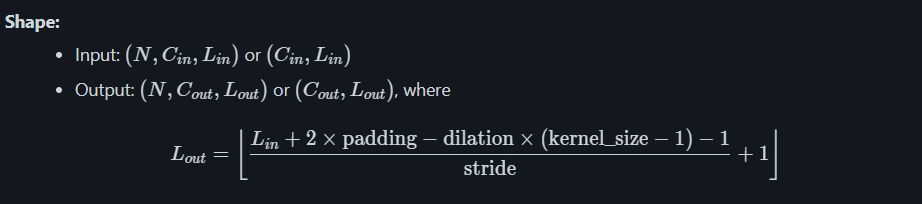

#### Conv Transpose
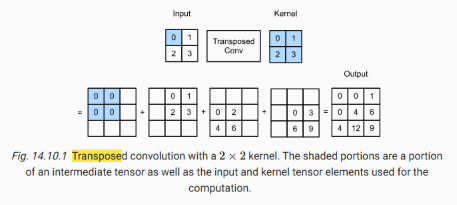
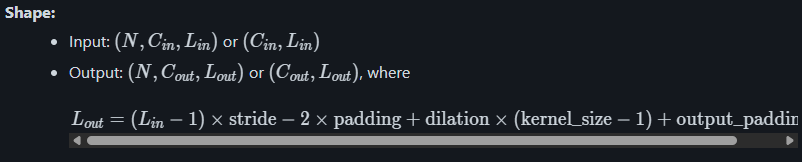

#### Group Normalization
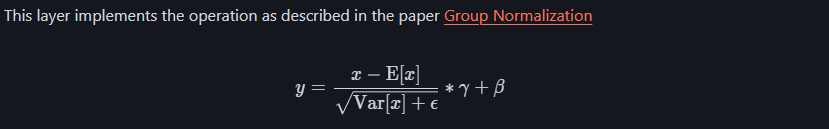

In [ ]:
class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=dim, 
                              out_channels=dim, 
                              kernel_size=3, 
                              stride=2, 
                              padding=1)

    def forward(self, x):
        return self.conv(x)


class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(in_channels=dim, 
                                       out_channels=dim, 
                                       kernel_size=4, 
                                       stride=2, 
                                       padding=1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            # Rearrange('batch channels horizon -> batch channels 1 horizon'),
            nn.GroupNorm(n_groups, out_channels),
            # Rearrange('batch channels 1 horizon -> batch channels horizon'),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)

In [13]:
### Sample input testing
BATCH_SIZE = 32
INPUT_DIM = 10

x = torch.randn(BATCH_SIZE, INPUT_DIM, INPUT_DIM)
print(f"x shape: {x.shape}")

down_sample = Downsample1d(dim=INPUT_DIM)
x_down_sample = down_sample(x)



x shape: torch.Size([32, 10, 10])


In [ ]:
class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 cond_dim,
                 kernel_size=3,
                 n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))       # batch t -> batch t 1
        )

        # make sure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:, 0, ...]
        bias = embed[:, 1, ...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out
    

class ConditionalUnet1D(nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Upsample1d(dim_in) if not is_last else nn.Identity()
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x
